In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
#Load the Dataset (downloaded from Kaggle)
df = pd.read_csv('application_train.csv')
print(df.shape)
df.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Data Cleaning
# Drop columns with too many missing values
missing = df.isnull().mean()
df = df.drop(columns=missing[missing > 0.5].index)

# Fill remaining missing values
df = df.fillna(df.median(numeric_only=True))

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   NAME_CONTRACT_TYPE            307511 non-null  object 
 3   CODE_GENDER                   307511 non-null  object 
 4   FLAG_OWN_CAR                  307511 non-null  object 
 5   FLAG_OWN_REALTY               307511 non-null  object 
 6   CNT_CHILDREN                  307511 non-null  int64  
 7   AMT_INCOME_TOTAL              307511 non-null  float64
 8   AMT_CREDIT                    307511 non-null  float64
 9   AMT_ANNUITY                   307511 non-null  float64
 10  AMT_GOODS_PRICE               307511 non-null  float64
 11  NAME_TYPE_SUITE               306219 non-null  object 
 12  NAME_INCOME_TYPE              307511 non-nul

In [ ]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.000000,189145.50000,278202.00000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000,0.00000,0.00000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000,0.00000,0.00000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.000000,112500.00000,147150.00000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.000000,270000.00000,513531.00000,808650.000000,4.050000e+06
...,...,...,...,...,...,...,...,...
ANNUITY_TO_CREDIT,307511.0,0.053695,0.022482,0.016790,0.03690,0.05000,0.064043,1.581133e-01
INCOME_PER_FAM_MEMBER,307511.0,57482.588156,65851.657398,2647.058824,33750.00000,49500.00000,67500.000000,2.925000e+07
CHILD_RATIO,307511.0,0.095379,0.152960,0.000000,0.00000,0.00000,0.250000,9.047619e-01
EXT_SOURCE_MEAN,307511.0,0.515099,0.135318,0.000269,0.42589,0.53212,0.615340,8.405519e-01


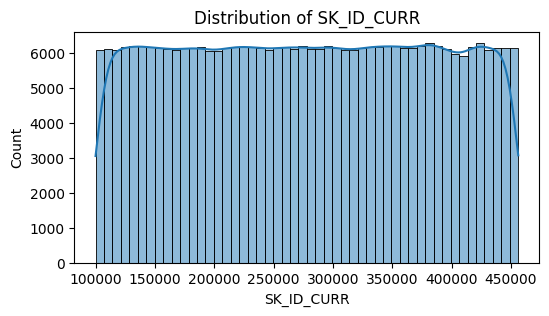

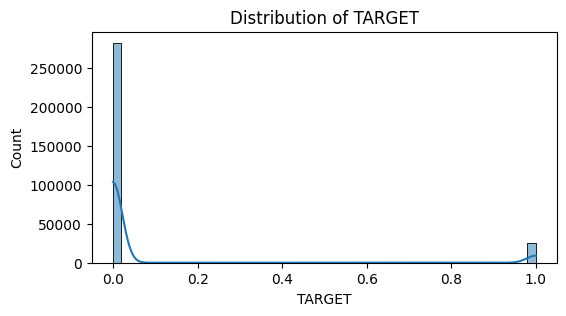

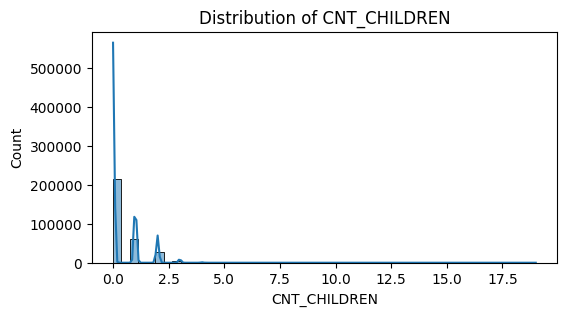

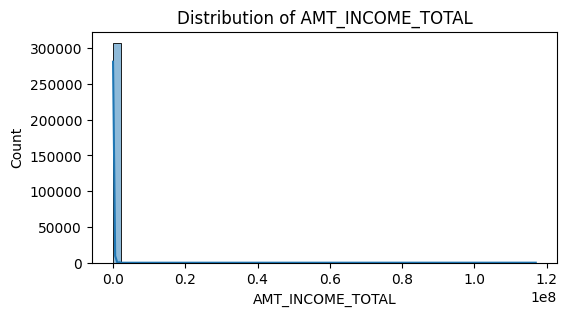

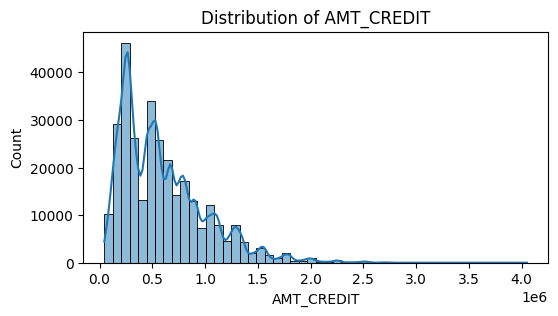

In [ ]:
for col in num_cols[:5]:  # Change to see more
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


In [ ]:
# Compute skewness for numeric columns
skewness = df[num_cols].apply(lambda x: skew(x.dropna()))
skewed_cols = skewness[skewness > 1].index.tolist()  # Skewness > 1 = highly skewed

# Make a copy BEFORE log transformation
original_df = df.copy()

# Apply log1p transformation in-place
for col in skewed_cols:
    if (df[col] >= 0).all(): # Only log-transform non-negative columns
        df[col] = np.log1p(df[col])

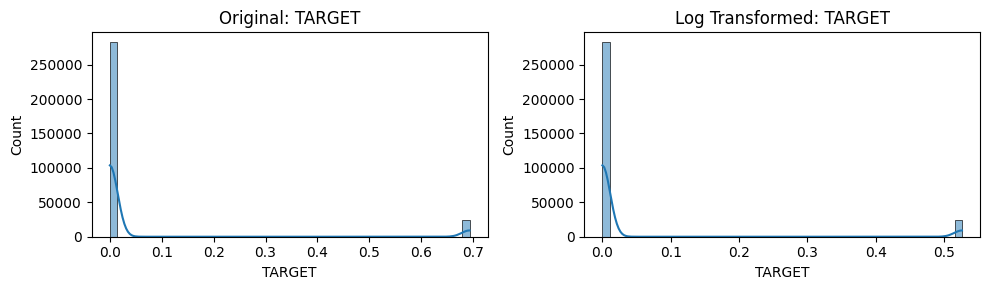

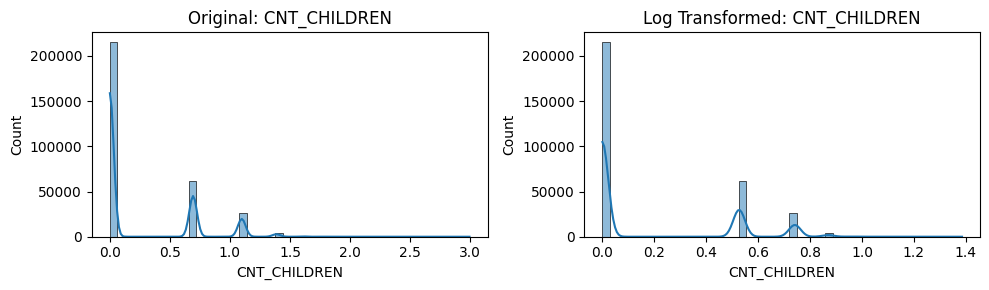

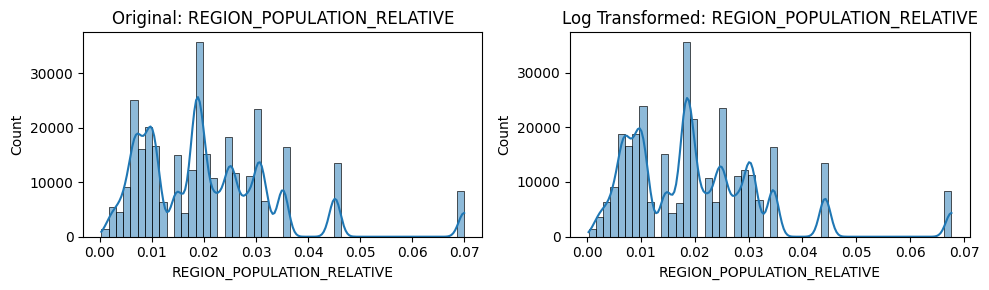

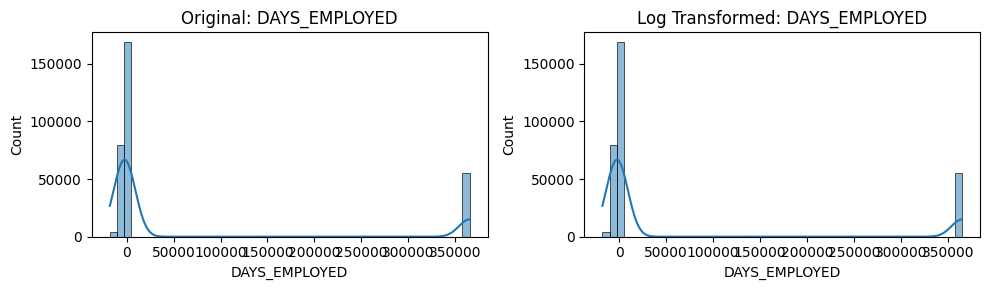

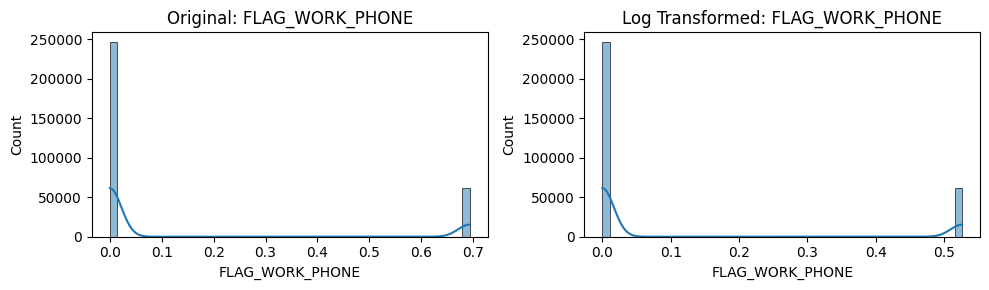

In [ ]:
# Compare histograms: Original vs Log Transformed
for col in skewed_cols[:5]:  # Limit to first 5
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    sns.histplot(original_df[col].dropna(), bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f'Original: {col}')

    sns.histplot(df[col].dropna(), bins=50, kde=True, ax=axs[1])
    axs[1].set_title(f'Log Transformed: {col}')

    plt.tight_layout()
    plt.show()

In [ ]:
print("Top 10 most skewed features:")
print(skewness.abs().sort_values(ascending=False).head(10))


Top 10 most skewed features:
FLAG_MOBIL          554.534039
FLAG_DOCUMENT_12    392.112866
FLAG_DOCUMENT_10    209.588031
FLAG_DOCUMENT_2     153.791067
FLAG_DOCUMENT_4     110.893823
FLAG_DOCUMENT_7      72.173756
FLAG_DOCUMENT_17     61.213842
FLAG_DOCUMENT_21     54.612673
FLAG_DOCUMENT_20     44.364680
FLAG_DOCUMENT_19     40.955935
dtype: float64


In [ ]:
cat_cols = df.select_dtypes(include='object').columns
print("Categorical Columns:", cat_cols,"\n")
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

Categorical Columns: Index([], dtype='object') 



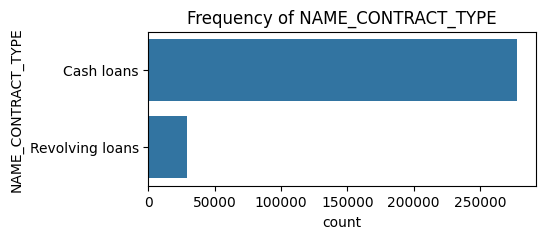

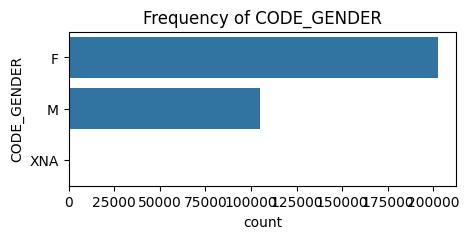

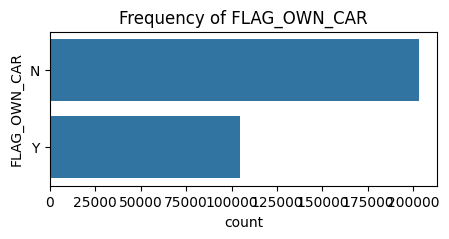

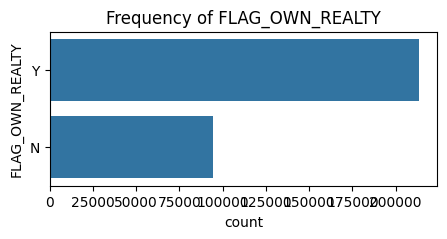

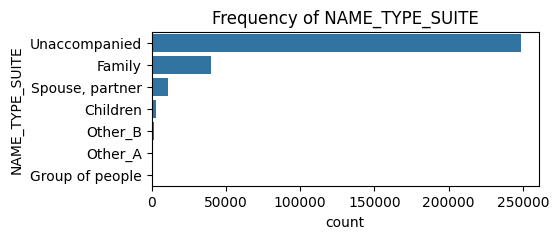

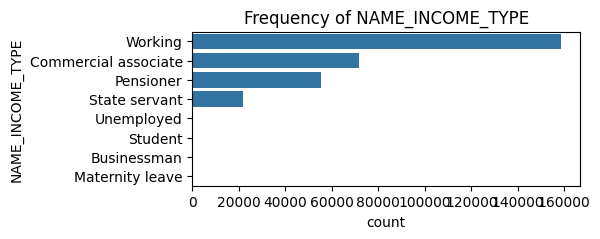

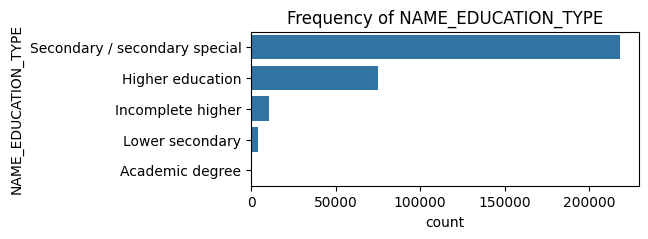

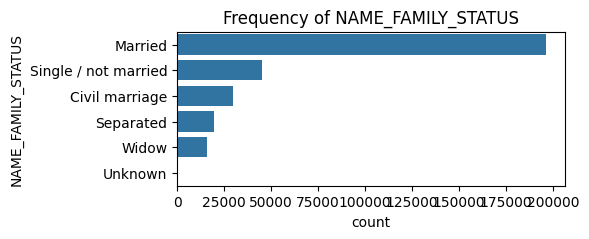

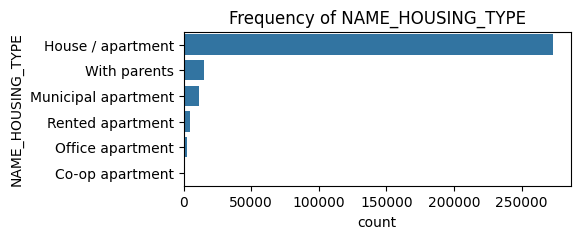

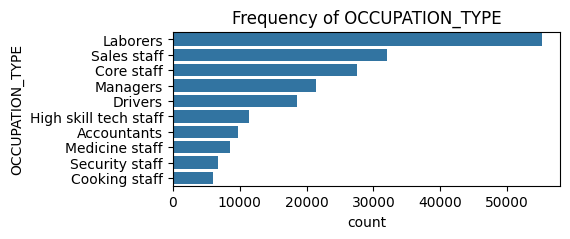

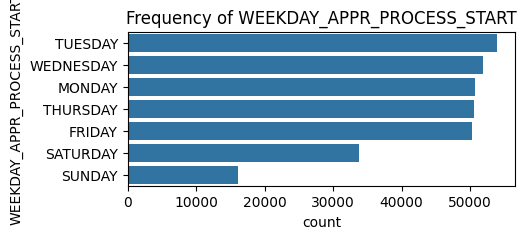

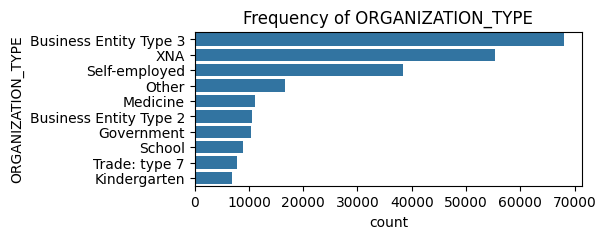

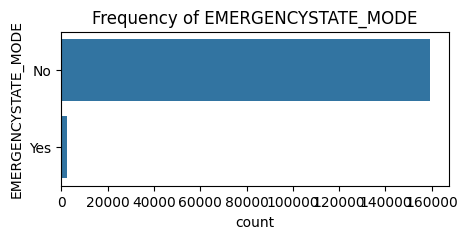

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(5,2))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:10])
    plt.title(f"Frequency of {col}")
    plt.show()

In [ ]:
for col in cat_cols:
    if df[col].nunique() <= 10:
        plt.figure(figsize=(5,2))
        sns.barplot(data=df, x=col, y='TARGET', estimator=np.mean)
        plt.title(f"Default Rate by {col}")
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
# Feature Engineering
# Encode categorical variables
df['AGE'] = abs(df['DAYS_BIRTH']) // 365
df['EMPLOYED_YEARS'] = abs(df['DAYS_EMPLOYED']).replace(365243, np.nan) // 365
df['LOAN_TO_INCOME'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
df = pd.get_dummies(df, drop_first=True)
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'] + 1)
df['ANNUITY_TO_INCOME'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
df['ANNUITY_TO_CREDIT'] = df['AMT_ANNUITY'] / (df['AMT_CREDIT'] + 1)
df['INCOME_PER_FAM_MEMBER'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)
df['CHILD_RATIO'] = df['CNT_CHILDREN'] / (df['CNT_FAM_MEMBERS'] + 1)

# Average of EXT_SOURCEs
ext_cols = [col for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] if col in df.columns]
df[ext_cols] = df[ext_cols].fillna(df[ext_cols].mean())
df['EXT_SOURCE_MEAN'] = df[ext_cols].mean(axis=1)

# Exponential weighted average of EXT_SOURCEs (simulated rolling effect)
if len(ext_cols) == 3:
    weights = np.array([0.1, 0.3, 0.6])
elif len(ext_cols) > 0:
    weights = np.ones(len(ext_cols)) / len(ext_cols)
else:
    weights = None
    print("No EXT_SOURCE columns found.")

# Compute EXP score only if we have valid weights
if weights is not None:
    df['EXT_SOURCE_EXP'] = df[ext_cols].dot(weights)


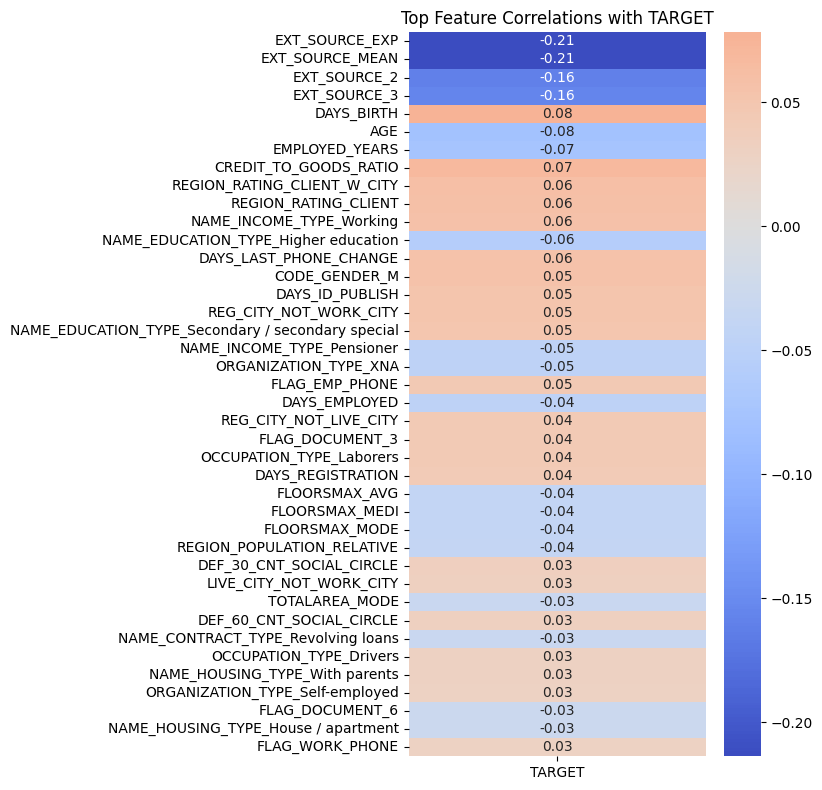

In [ ]:
# Calculate correlations
corr = df.corr(numeric_only=True)

# Get correlation with TARGET only (drop TARGET itself)
target_corr = corr['TARGET'].drop('TARGET').sort_values(key=abs, ascending=False)

# Filter only top N features with highest absolute correlation
top_n = 40
top_features = target_corr.head(top_n).index

# Final heatmap
plt.figure(figsize=(8, top_n * 0.2))
sns.heatmap(corr.loc[top_features, ['TARGET']], annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Top Feature Correlations with TARGET")
plt.tight_layout()
plt.show()

# EXT_SOURCE_3: Higher score → less likely to default
# AGE: Older people are less likely to default
# LOAN_TO_INCOME: Higher burden → more likely to default
# Weak values (0.05 or lower): might not be strong predictors on their own

In [ ]:
# Train-Test Split & Scaling
# Select features and target
X = df.drop(columns='TARGET')
y = df['TARGET']

# Keep only numeric columns (after encoding)
X = X.select_dtypes(include='number')

# Fill missing values
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
#Apply SMOTE on training data to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE: ", np.bincount(y_train_smote))

Before SMOTE: [226148  19860]
After SMOTE:  [226148 226148]


In [ ]:
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=8, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50, max_depth=5),
    "LightGBM": lgb.LGBMClassifier(n_estimators=50, max_depth=5)
}

In [ ]:
# Model Training and Evaluation
def evaluate_model(model, name, X_train, y_train, X_test, y_test, threshold=0.5):
    # Train
    model.fit(X_train, y_train)
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    # Apply custom threshold
    y_pred = (y_proba >= threshold).astype(int)
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Output
    print(f"\n{name} (Threshold = {threshold}):")
    print(f"Accuracy : {acc:.3f}")
    print(f"ROC AUC  : {auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall   : {recall:.3f}")
    print(f"F1 Score : {f1:.3f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

# Evaluate all models at custom threshold (e.g., 0.3)
for name, model in models.items():
    evaluate_model(model, name, X_train_smote, y_train_smote, X_test, y_test, threshold=0.3)



Logistic Regression (Threshold = 0.3):
Accuracy : 0.700
ROC AUC  : 0.624
Precision: 0.125
Recall   : 0.453
F1 Score : 0.196
Confusion Matrix:
 [[40794 15744]
 [ 2715  2250]]
Classification Report:
               precision    recall  f1-score   support

           0      0.938     0.722     0.815     56538
           1      0.125     0.453     0.196      4965

    accuracy                          0.700     61503
   macro avg      0.531     0.587     0.506     61503
weighted avg      0.872     0.700     0.765     61503


Random Forest (Threshold = 0.3):
Accuracy : 0.543
ROC AUC  : 0.670
Precision: 0.120
Recall   : 0.736
F1 Score : 0.206
Confusion Matrix:
 [[29720 26818]
 [ 1309  3656]]
Classification Report:
               precision    recall  f1-score   support

           0      0.958     0.526     0.679     56538
           1      0.120     0.736     0.206      4965

    accuracy                          0.543     61503
   macro avg      0.539     0.631     0.443     61503
weighted 

In [ ]:
#comparison of different models
comparison = {
    "Model": ["Logistic", "Random Forest", "XGBoost", "LightGBM"],
    "Accuracy": [0.700, 0.535, 0.893, 0.811],
    "Precision": [0.125, 0.120, 0.256, 0.170],
    "Recall": [0.453, 0.749, 0.173, 0.343],
    "F1 Score": [0.196, 0.206, 0.207, 0.227],
    "ROC AUC": [0.624, 0.669, 0.715, 0.691]
}

df_compare = pd.DataFrame(comparison)
df_compare
df_compare.style.highlight_max(color='lightgreen', axis=0)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic,0.700000,0.125000,0.453000,0.196000,0.624000
1,Random Forest,0.535000,0.120000,0.749000,0.206000,0.669000
2,XGBoost,0.893000,0.256000,0.173000,0.207000,0.715000
3,LightGBM,0.811000,0.170000,0.343000,0.227000,0.691000


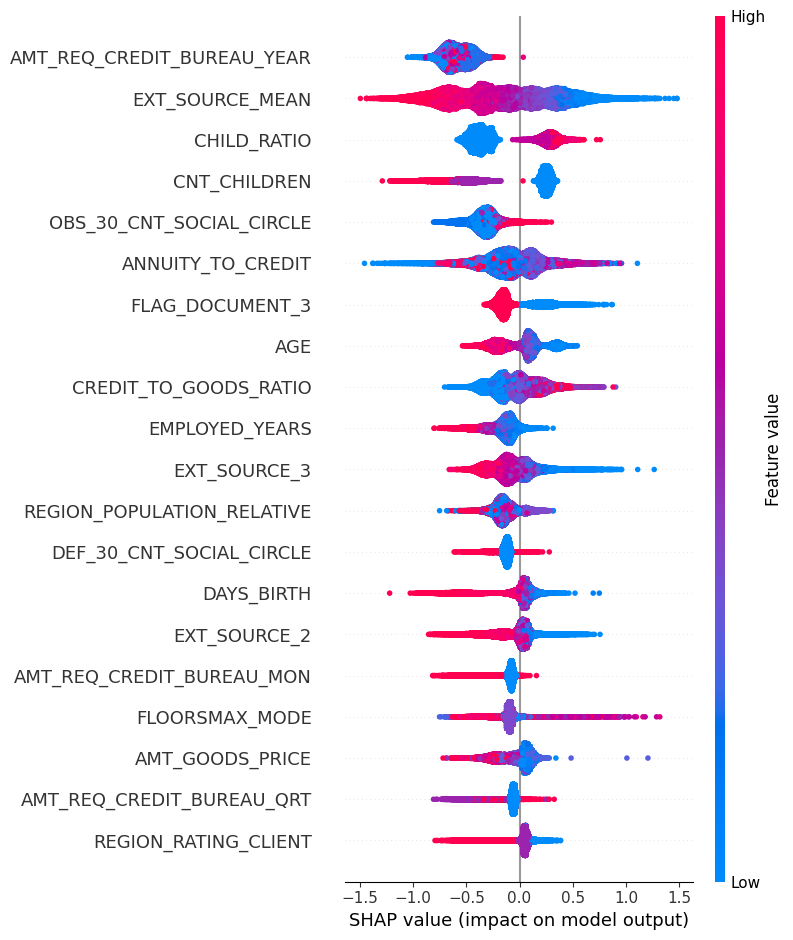

In [ ]:
# SHAP Feature Importance with XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_smote, y_train_smote)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [ ]:
# Retrain with Top 20 Features
importances = xgb.feature_importances_
top_features_indices = np.argsort(importances)[-20:]
X_train_top = X_train_smote[:, top_features_indices]
X_test_top = X_test[:, top_features_indices]
xgb.fit(X_train_top, y_train_smote)
y_pred_top = xgb.predict(X_test_top)
print("\nXGBoost Retrained on Top Features:")
print(classification_report(y_test, y_pred_top))


XGBoost Retrained on Top Features:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56538
           1       0.18      0.04      0.06      4965

    accuracy                           0.91     61503
   macro avg       0.55      0.51      0.51     61503
weighted avg       0.86      0.91      0.88     61503

